In [18]:
%matplotlib inline
from __future__ import division
import numpy as np
from sklearn.mixture import GMM
import matplotlib.pyplot as plt
from IPython.display import Image

# TODO try to avoid the need of the sys.path.apppend call
import sys
sys.path.append("..")
from cwc.models.density_estimators import MyMultivariateNormal
from cwc.models.background_check import BackgroundCheck

plt.rcParams['figure.figsize'] = (12,4)

# Background check

Imagine a simple classification example between lemons and oranges where the only feature is the relative size to a tennis ball. We are denoting to be a small fruit if it is smaller than a tennis ball and big otherwise.

We can define the next notation for the different fruits and sizes:

- $F$: Fruit
- $L$: Lemon
- $O$: Orange
- $S$: Small
- $B$: Big

Then, we can colect some lemons and oranges and try to estimate what are the different probabilities. In order to get these examples all the fruits that are not lemons or oranges are discarded as we do not need to classify between other fruits. Then we get a cleaned sample containing only the desired lemons and orange with their respective relative size to a tennis ball.

In [19]:
Image(url='./images/example.svg')

In [20]:
size_of_tennis_ball = 1
fruits = np.array(['lemon', 'lemon', 'orange', 'lemon', 'orange'])
sizes  = np.array([0.7, 0.8, 0.9, 1.1, 1.2])

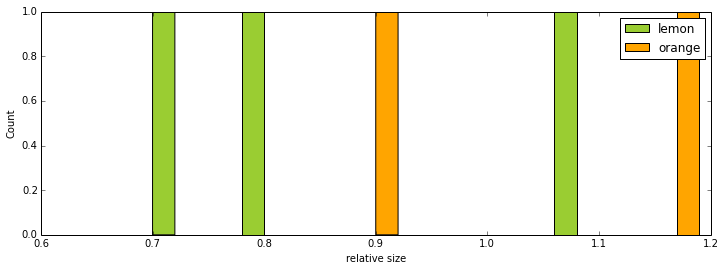

In [21]:
plt.hist(sizes[fruits == 'lemon'], color='yellowgreen', label='lemon', width=0.02)
plt.hist(sizes[fruits == 'orange'], color='orange', label='orange', width=0.02)
plt.legend()
plt.xlabel('relative size')
plt.ylabel('Count')

With this small set of examples we can start estimating the different probabilities of being a specific fruit or size. Then, we will denote the different probabilities as:

- $P(L)$ = Prior probability of being a Lemon

$$ P(L) \sim \frac{|L|}{|F|} \sim \frac{|L|}{|L|+|O|}$$
- $P(S)$ = Prior probability of being Small (smaller than a tennis ball)

$$ P(S) \sim \frac{|S|}{|F|} \sim \frac{|S|}{|S|+|B|}$$
- $P(S|L)$ = Probability of being small given that we know that it is a lemon
$$ P(S|L) \sim \frac{|L| \bigcap |S|}{|L|}$$

Then we can compute these estimates with our small sample:

In [22]:
P_L = np.mean(fruits == 'lemon')
P_S = np.mean(sizes < size_of_tennis_ball)
P_S_g_L = np.logical_and(fruits == 'lemon', sizes < size_of_tennis_ball).sum()/(fruits == 'lemon').sum()

print('P(L) = {0:1.2f}%'.format(P_L))
print('P(S) = {0:1.2f}%'.format(P_S))
print('P(S|L) = {0:1.2f}%'.format(P_S_g_L))

P(L) = 0.60%
P(S) = 0.60%
P(S|L) = 0.67%


Now that we have this information we can try to estimate what is the probability of getting a lemon or an orange given a specific size.

Bayes theorem states that:

$$
    P(L|S) = \frac{P(S|L)*P(L)}{P(S)} = \frac{P(S|L)*P(L)}{P(S|L)*P(L) + P(S|\bar L)*P(\bar L)}
$$

However, because it is not possible to estimate $P(S)$ for all the possible objects, it is assumed that we can get an estimate in our given sample with lemons and apples. In our case, we are assuming that all the objects that are not lemons are apples. Then Bayes' theorem can be written as:

$$
    P(L|S) = \frac{P(S|L)*P(L)}{P(S)} = \frac{P(S|L)*P(L)}{P(S|L)*P(L) + P(S|A)*P(A)}
$$

Where $P(A)$ is the probability of being an apple and $P(S|A)$ is the probability of being small given that it is an apple.

In [23]:
P_L_S = P_S_g_L*P_L/P_S

print('P(L|S) = {0:1.2f}%'.format(P_L_S))

P(L|S) = 0.67%


## Deployment time

However, during deployment time there is nobody that can asure that the fruits that are being predicted are only lemons and oranges. It is possible that the factory got some other fruits in the collecting time.

In [24]:
Image(url='./images/example_2.svg')

In [25]:
fruits = np.array(['strawberry', 'strawberry', 'strawberry', 'lemon', 'lemon', 'apple', 'orange', 'orange', 'apple', 'lemon'])
sizes  = np.array([.3, .33, .36, .7, .8, .85, .9, 1.1, 1.15, 1.2])

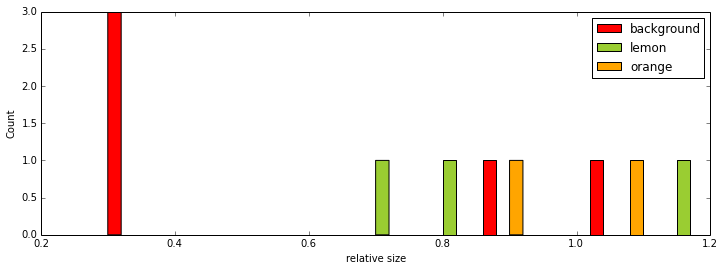

In [26]:
plt.hist(sizes[np.logical_not(np.in1d(fruits, ['lemon', 'apple']))], color='red', label='background', width=0.02)
plt.hist(sizes[fruits == 'lemon'], color='yellowgreen', label='lemon', width=0.02)
plt.hist(sizes[fruits == 'orange'], color='orange', label='orange', width=0.02)
plt.legend()
plt.xlabel('relative size')
plt.ylabel('Count')

$$
    P(L|S) = \frac{P(S|L)*P(L)}{P(S)} = \frac{P(S|L)*P(L)}{P(S|L)*P(L) + P(S|A)*P(A) + P(S|\bar A, \bar L)*P(\bar A,\bar L)}
$$

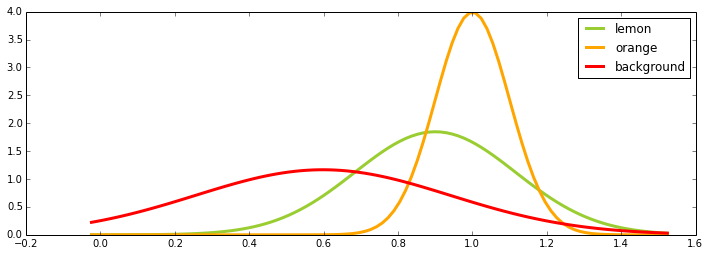

In [27]:
estimator_lemons = MyMultivariateNormal()
estimator_lemons.fit(sizes[fruits == 'lemon'])
estimator_oranges = MyMultivariateNormal()
estimator_oranges.fit(sizes[fruits == 'orange'])
estimator_background = MyMultivariateNormal()
estimator_background.fit(sizes[np.logical_and(fruits != 'lemon', fruits != 'orange')])

sizes_linspace = np.linspace(sizes.min()-sizes.std(), sizes.max()+sizes.std(), 100).reshape(-1,1)

plt.plot(sizes_linspace, estimator_lemons.score(sizes_linspace), color='yellowgreen', label='lemon', linewidth=3)
plt.plot(sizes_linspace, estimator_oranges.score(sizes_linspace), color='orange', label='orange', linewidth=3)
plt.plot(sizes_linspace, estimator_background.score(sizes_linspace), color='red', label='background', linewidth=3)
plt.legend()

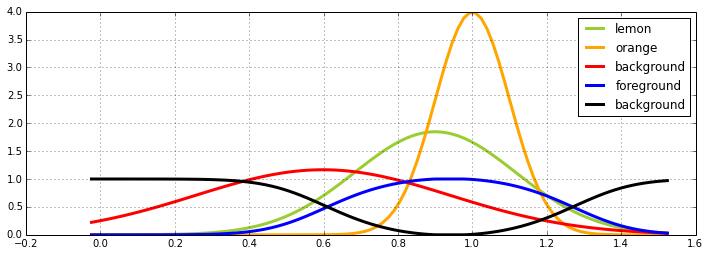

In [28]:
estimator_foreground = BackgroundCheck(mu=0.0, m=1.0)
estimator_foreground.fit(sizes[np.logical_or(fruits == 'lemon', fruits == 'orange')].reshape(-1,1))

plt.plot(sizes_linspace, estimator_lemons.score(sizes_linspace), color='yellowgreen', label='lemon', linewidth=3)
plt.plot(sizes_linspace, estimator_oranges.score(sizes_linspace), color='orange', label='orange', linewidth=3)
plt.plot(sizes_linspace, estimator_background.score(sizes_linspace), color='red', label='background', linewidth=3)
plt.plot(sizes_linspace, estimator_foreground.predict_proba(sizes_linspace)[:,1], color='blue', label='foreground', linewidth=3)
plt.plot(sizes_linspace, estimator_foreground.predict_proba(sizes_linspace)[:,0], color='black', label='background', linewidth=3)
plt.legend()
plt.grid(True)

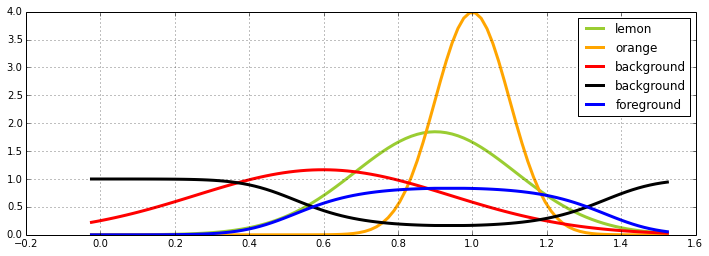

In [29]:
estimator_foreground = BackgroundCheck(mu=0.2, m=0.5)
estimator_foreground.fit(sizes[np.logical_or(fruits == 'lemon', fruits == 'orange')].reshape(-1,1))

plt.plot(sizes_linspace, estimator_lemons.score(sizes_linspace), color='yellowgreen', label='lemon', linewidth=3)
plt.plot(sizes_linspace, estimator_oranges.score(sizes_linspace), color='orange', label='orange', linewidth=3)
plt.plot(sizes_linspace, estimator_background.score(sizes_linspace), color='red', label='background', linewidth=3)
plt.plot(sizes_linspace, estimator_foreground.predict_proba(sizes_linspace)[:,0], color='black', label='background', linewidth=3)
plt.plot(sizes_linspace, estimator_foreground.predict_proba(sizes_linspace)[:,1], color='blue', label='foreground', linewidth=3)
plt.legend()
plt.grid(True)

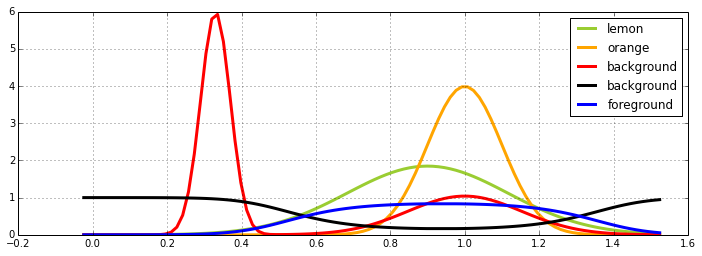

In [30]:
estimator_background = GMM(n_components=2)
estimator_background.fit(sizes[np.logical_and(fruits != 'lemon', fruits != 'orange')].reshape(-1,1))

plt.plot(sizes_linspace, estimator_lemons.score(sizes_linspace), color='yellowgreen', label='lemon', linewidth=3)
plt.plot(sizes_linspace, estimator_oranges.score(sizes_linspace), color='orange', label='orange', linewidth=3)
plt.plot(sizes_linspace, np.exp(estimator_background.score(sizes_linspace)), color='red', label='background', linewidth=3)
plt.plot(sizes_linspace, estimator_foreground.predict_proba(sizes_linspace)[:,0], color='black', label='background', linewidth=3)
plt.plot(sizes_linspace, estimator_foreground.predict_proba(sizes_linspace)[:,1], color='blue', label='foreground', linewidth=3)
plt.legend()
plt.grid(True)

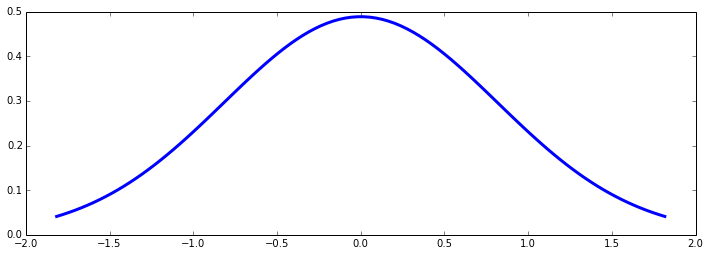

In [31]:
mvn = MultivariateNormal()
x_train = np.array([-1, 0, 1]).T
mvn.fit(x_train)

x_test = np.linspace(x_train.min()-x_train.std(), x_train.max()+x_train.std(), 100).reshape(-1,1)

plt.plot(x_test, mvn.score(x_test), linewidth=3)